In [1]:
import pyBigWig
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib as mpl
import matplotlib.font_manager as font_manager

# Variables setting

In [45]:
font_dir = '../fonts/'
images_dir='../images/'
regions_dir='../data/regions/'
cov_dir="../data/coverage/"
flank=10000
sns.set_style("whitegrid")

# Fonts

In [8]:
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
mpl.rcParams['font.family'] = 'Arial'

# Get the data and merge cluster of loci into groups

In [12]:
provirus=pd.read_csv(regions_dir+"Hd2_provirus_loci_IVSPER2_grouped.gtf", sep="\t", names=('scaffold', 'source', 'type', 'start', 'end', 'score', 'strand', 'frame', 'name', 'group'), usecols=('scaffold', 'start', 'end', 'name', 'group'))
provirus['group']=provirus['group'].fillna(value=provirus['name'])
provirus=pd.merge(provirus,provirus.groupby(['group'])['start'].min(), left_on='group', right_on='group')
provirus=pd.merge(provirus,provirus.groupby(['group'])['end'].max(), left_on='group', right_on='group')
provirus.rename(columns={'start_x':'start','end_x':'end','start_y':'group start','end_y':'group end'}, inplace=True)
provirus_group_df=provirus.loc[:,['scaffold','group','group start' ,'group end']].drop_duplicates().set_index('group')

In [25]:
df_all = pd.DataFrame({'group' :  pd.Series(dtype='str'), 
                                'scaff':  pd.Series(dtype='str'),
                                'position':  pd.Series(dtype='int32'),
                                'value':  pd.Series(dtype='float32'), 
                                'locus':  pd.Series(dtype='str')})
for i in provirus_group_df.index:
    scaff=provirus_group_df.loc[i,'scaffold']
    bw= pyBigWig.open(cov_dir+scaff+"_St3vs1.10.bw")
    scaff_size=bw.chroms(scaff)
    start=provirus_group_df.loc[i,'group start']-flank
    if (start<0):start=0
    end=provirus_group_df.loc[i,'group end']+flank
    if(end>scaff_size):end=scaff_size
    df=pd.DataFrame(data=bw.intervals(scaff,start,end), columns=('position','end', 'value'))
    df['scaff']=scaff
    df['group']=i
    df['range']=df.index
    #df['position']=df['position']-start+1
    df['position']=df['position']s
    #print(df.loc[:,('name','position', 'value')])
    df_all=pd.concat([df_all,df.loc[:,('range','group','position','value', 'scaff')]],)
df_all.loc[:,'locus']=0

## In each group determine set the  locus value at the name of the included locus, and a non null number in-between loci 

In [28]:
locus_num={}
for locus in provirus['name']:
    locus_start=provirus.loc[provirus['name']==locus,'start'].values[0]
    locus_end=provirus.loc[provirus['name']==locus,'end'].values[0]
    for group in df_all['group'].unique():
        if (group not in locus_num): locus_num[group]=0
        if (locus in group.split(" ")):
            df_all.loc[(df_all['group']==group) & (df_all['position']>=locus_start) & (df_all['position']<=locus_end),'locus']=locus
            df_all.loc[(df_all['group']==group) & (df_all['position']>locus_end) & (df_all['locus'] == locus_num[group]),'locus']=locus_num[group]+1
            locus_num[group]=locus_num[group]+1
            continue

In [38]:
mycolors = ["#000000", "#f20e1c", "#000000","#f20e1c", "#000000", "#f20e1c","#000000"]
myPalette = sns.set_palette(sns.color_palette(mycolors))

<Axes: xlabel='position', ylabel='value'>

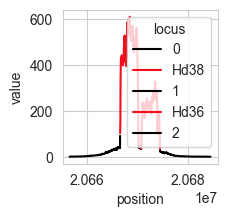

In [40]:
plt.figure(figsize=(2,2))
test=df_all.loc[df_all['group']=='Hd38 Hd36', :]
test["locus"].unique()
sns.lineplot(x="position", y="value",hue="locus", palette=myPalette, data=test)

# Figure with all the RU

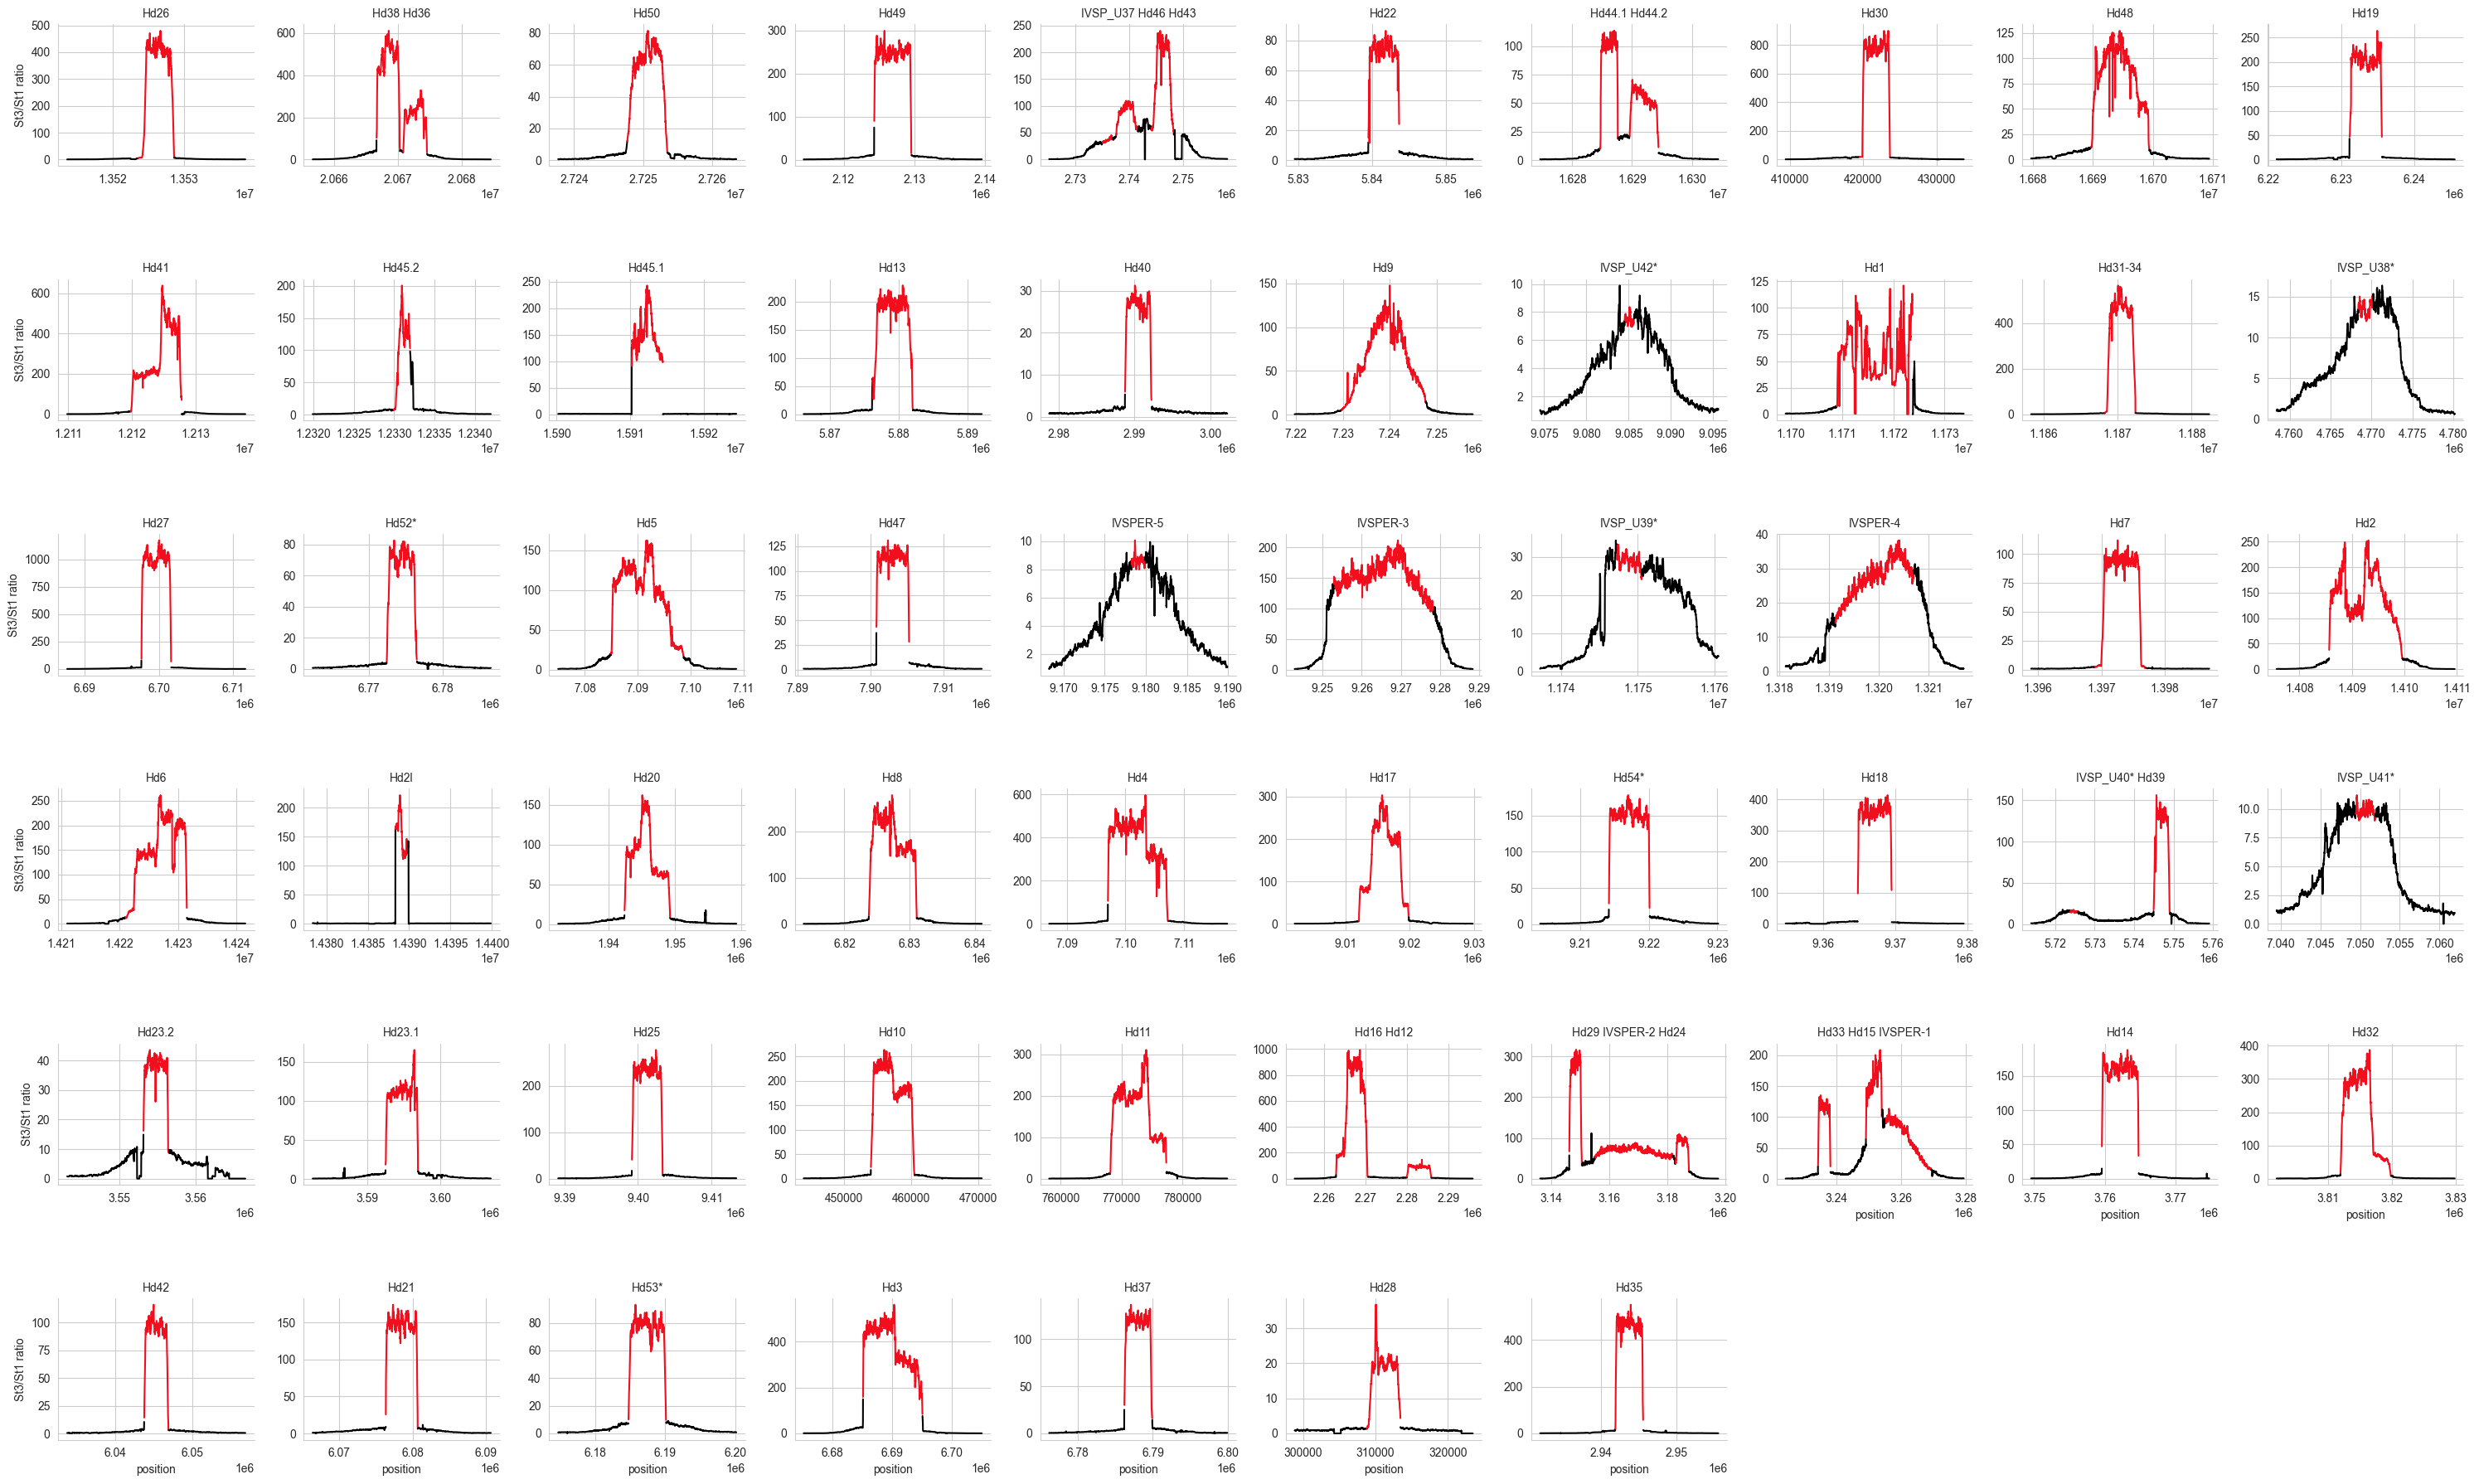

In [46]:
g = sns.FacetGrid(df_all, col="group", margin_titles=True, sharex=False, sharey=False, col_wrap=10)
g.map(sns.lineplot, "position", "value", "locus", palette=myPalette)
g.set_titles("{col_name}") 
plt.subplots_adjust(hspace=0.8)
g.set_ylabels("St3/St1 ratio")
#plt.tight_layout()
plt.savefig(images_dir+"all_RUgraph.png")

# Figures with the RU by scaffolds

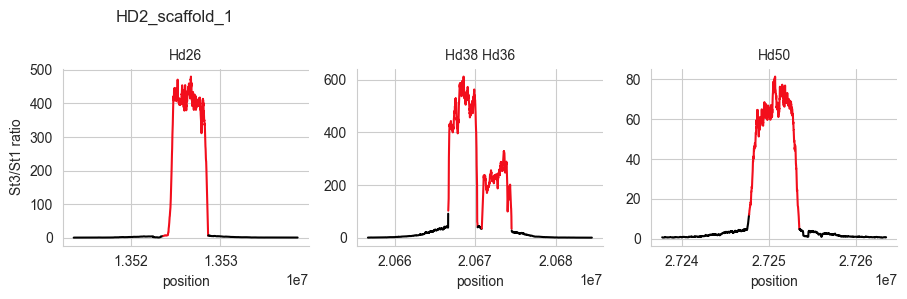

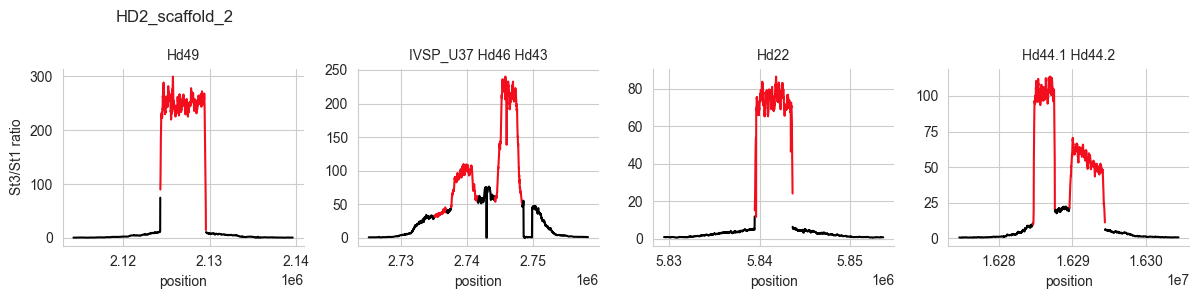

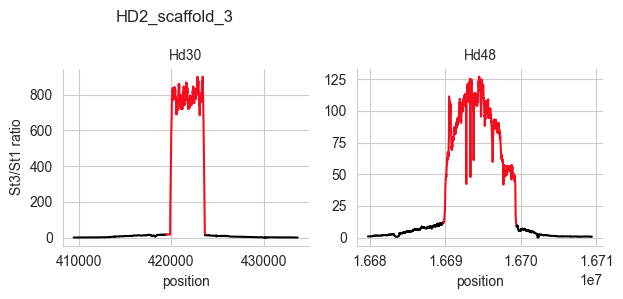

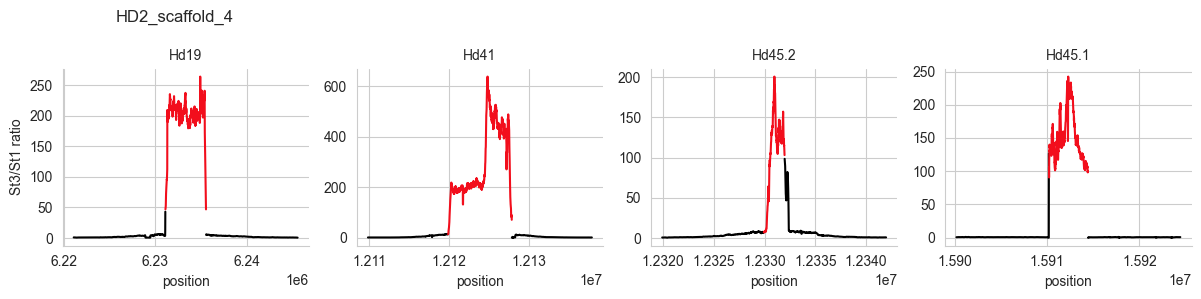

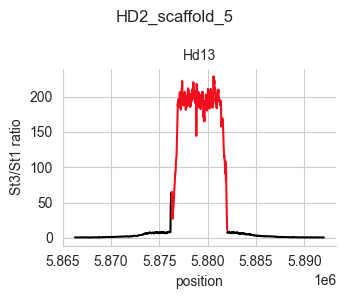

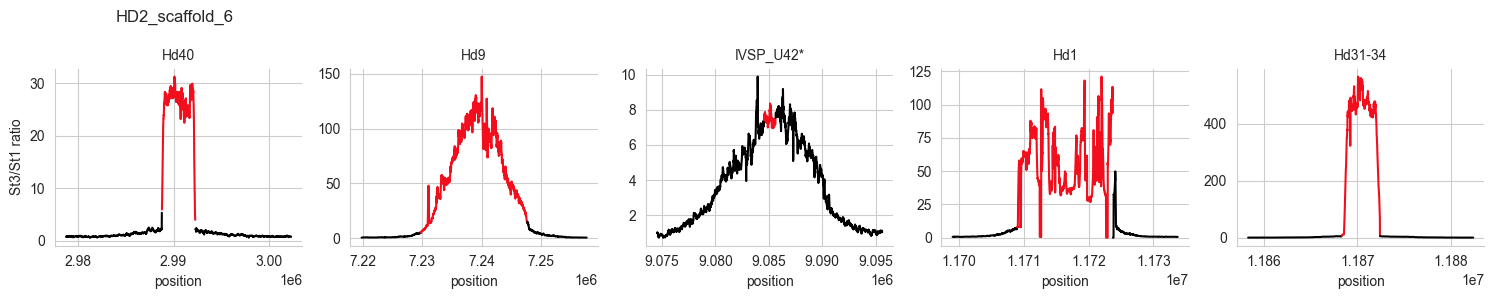

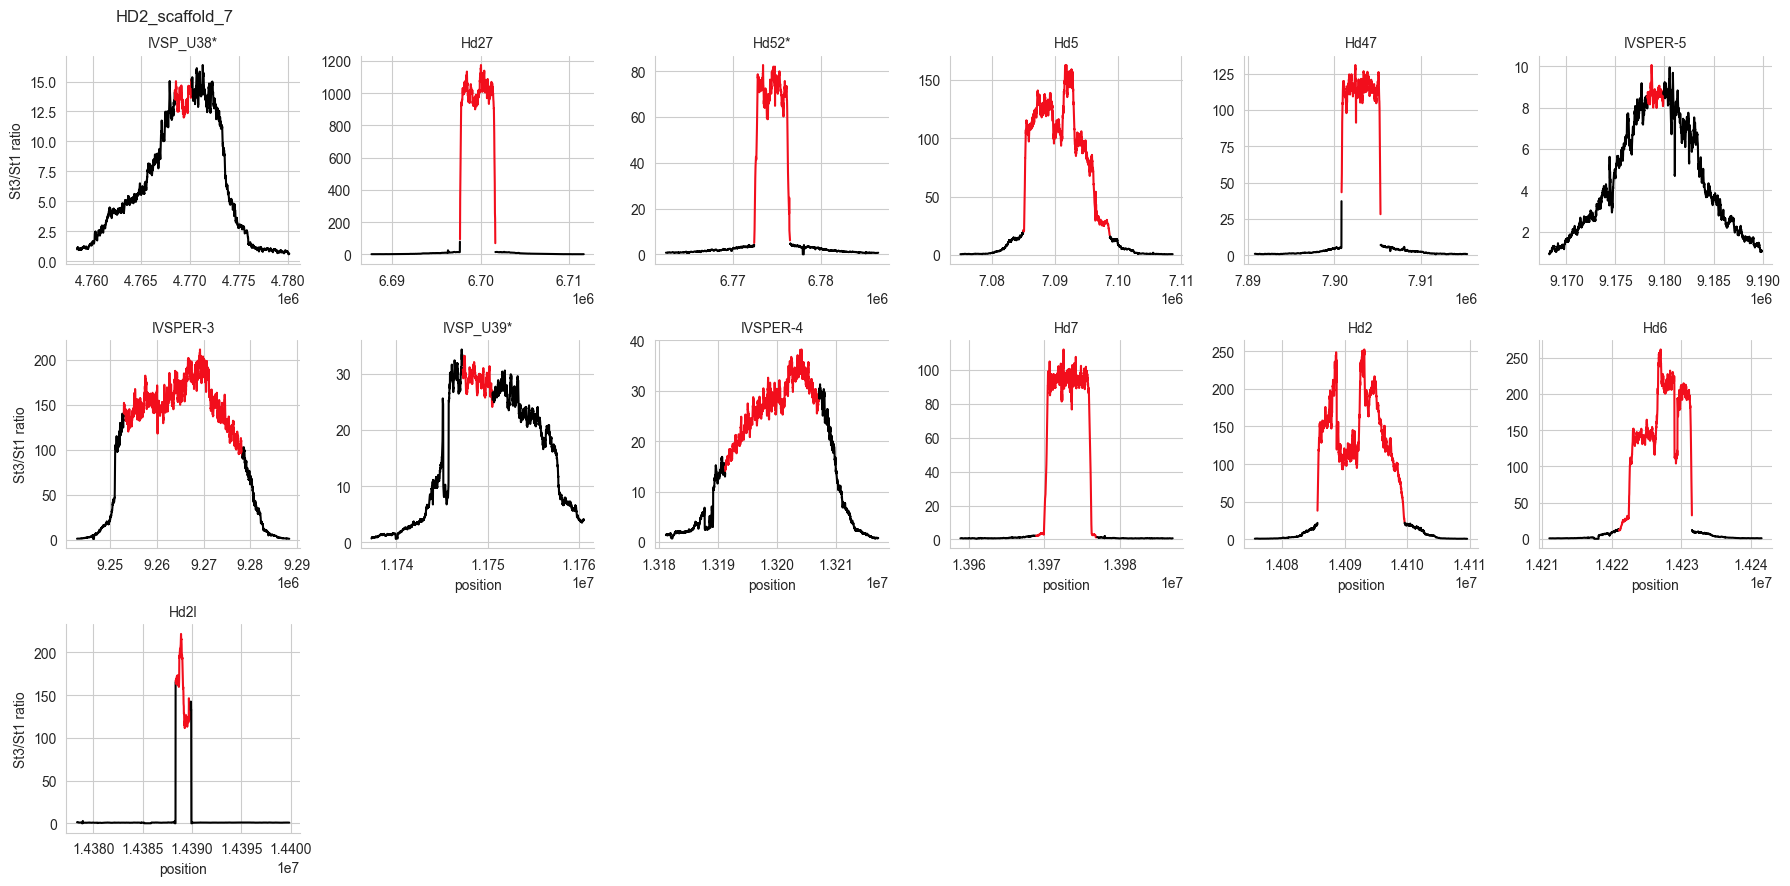

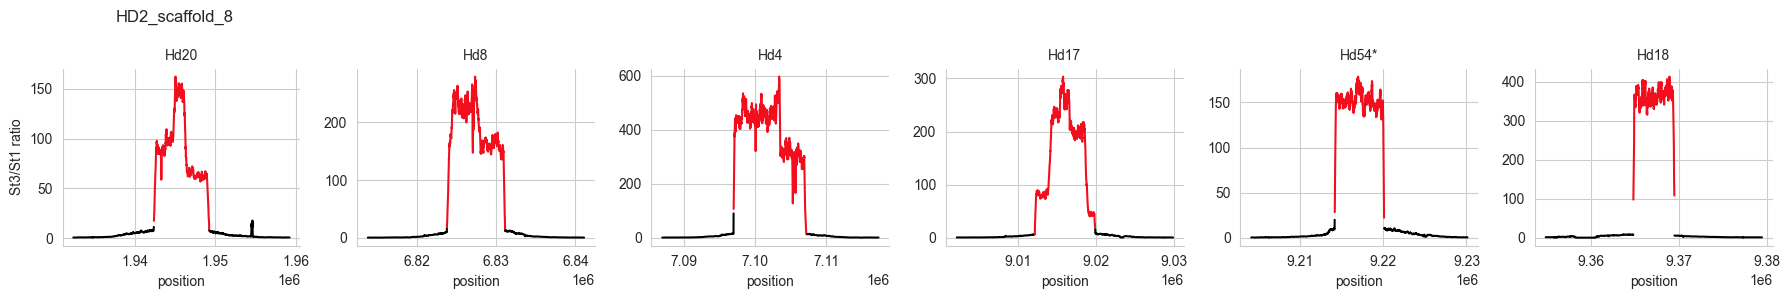

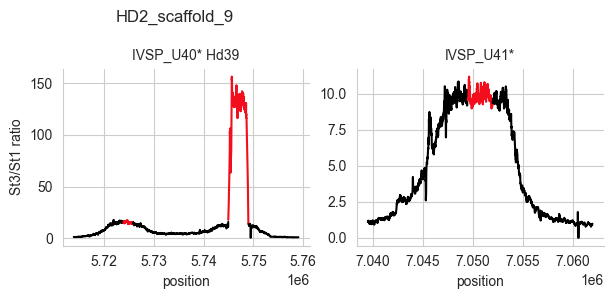

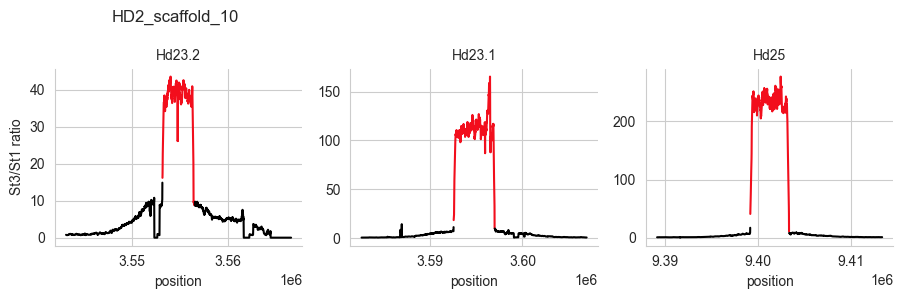

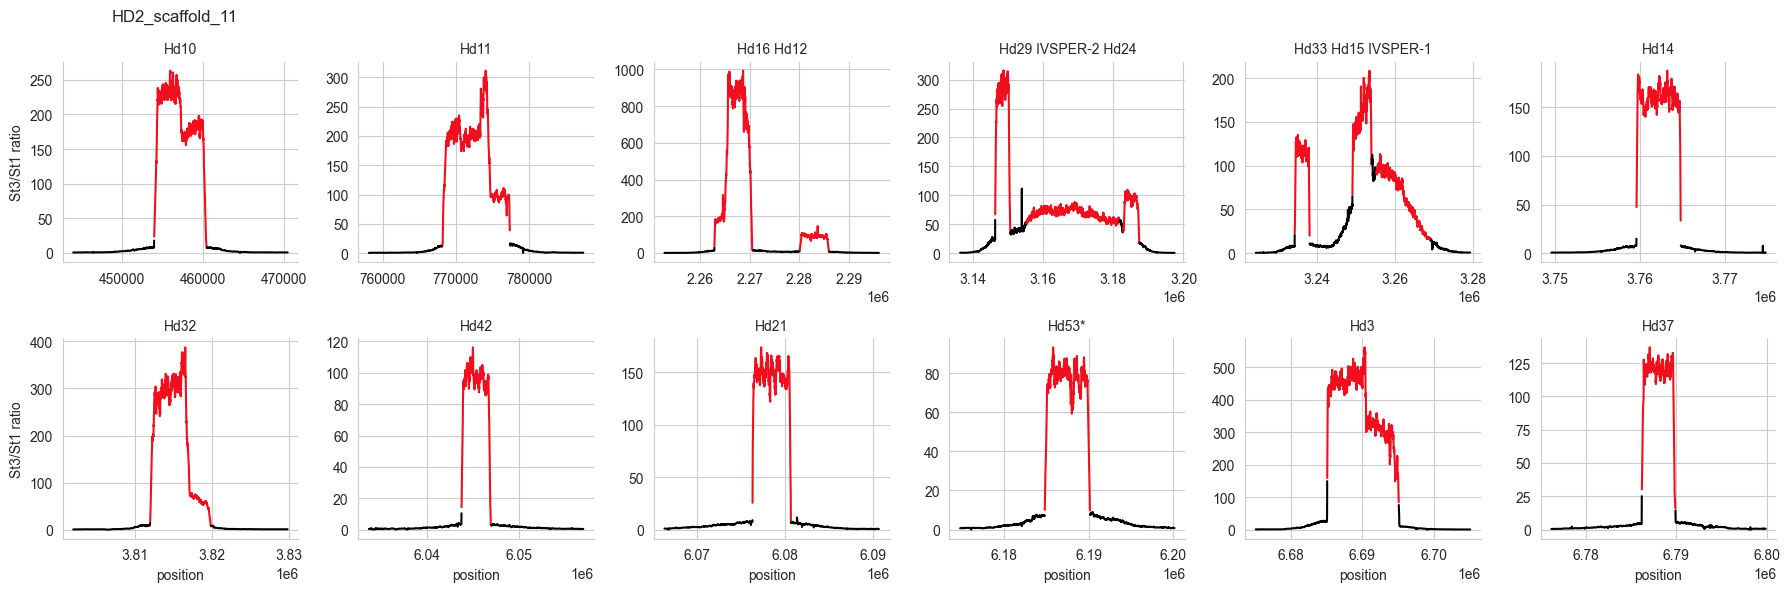

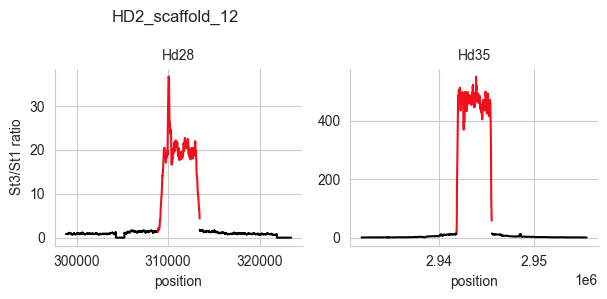

In [47]:
for s in df_all['scaff'].unique():
    d=df_all.loc[df_all['scaff']==s,:]
    g = sns.FacetGrid(d, col="group", margin_titles=True, sharex=False, sharey=False, col_wrap=6,aspect=1)
    g.map(sns.lineplot, "position", "value", "locus", palette=myPalette)
    g.set_titles("{col_name}")
    g.set_ylabels("St3/St1 ratio")
    plt.suptitle(s, size='large', x=0.1)
    plt.tight_layout()  
    plt.savefig(images_dir+"RU_"+s+".png")
